## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
for module_dir in ['visionfuncs', 'EPypes', 'vcalib']: 

    m_path = os.path.join('libraries', module_dir)
    if m_path not in sys.path:
        sys.path.append(m_path)
    
from visionfuncs.io import sorted_glob
from visionfuncs.io import open_image
from visionfuncs import geometry

from epypes.compgraph import CompGraphRunner

from vcalib import calibrun
from vcalib import planefit
from vcalib import calibim
from vcalib import nputils
from vcalib import imsubsets
from vcalib import viz

from vcalib.pipelineclasses import CalibrationInput, CalibTriang, MeanDistInRows, MaskedValues

## Helper functions

In [5]:
def load_pickle(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj


def plot_hist0_maxabserr(df, color_data, color_meaning, colormap='PiYG'):
    
    ax = plt.gca()
    
    sc = ax.scatter(df.Hist0, df.MaxAbsErr, c=color_data, cmap=colormap)
    ax.set_xlabel('Number of cases with absolute error within 0 and 0.1 mm')
    ax.set_ylabel('Maximal absultute error')
    plt.colorbar(sc, ax=ax, label=color_meaning)
    
    
def plot_scatter_with_colorbar(x, y, color_data, color_meaning, colormap='PiYG'):
    
    ax = plt.gca()
    
    sc = ax.scatter(x, y, c=color_data, cmap=colormap)
    plt.colorbar(sc, ax=ax, label=color_meaning)
    
    
def plot_histograms_for_ranks(df, n_images, step_size):

    color_list = ['tab:green'] + ['tab:blue' for i in range(9)] + ['tab:red']

    chosen_ranks = list(range(0, len(df), step_size))
    n_ranks = len(chosen_ranks)
    n_rows = n_ranks // 2 + n_ranks % 2

    plt.figure(figsize=(10, 12))

    for i, rank in enumerate(chosen_ranks):

        row = df.iloc[rank]
        hist = row[['Hist{}'.format(j) for j in range(11)]]

        heights = hist / n_images

        plt.subplot(n_rows, 2, i + 1)
        plt.ylim(top=0.65)
        plt.bar(hist.index, heights, color=color_list)
        plt.xticks(range(11), range(11))
        plt.title('Calibration run of rank {}'.format(rank + 1))

    plt.tight_layout()
    
    
def check_labels(labels, df):

    m1 = df[kmeans.labels_ == 1].NGoodImages.mean()
    m0 = df[kmeans.labels_ == 0].NGoodImages.mean()

    if m1 < m0: 
        # flip 0 and 1
        return np.array(kmeans.labels_ == 0, dtype=int)

    return labels


def gather_from_df_acc_for_consecutive_groups(df_acc, colname, group_size, n_groups):
    
    res = []
    groups = []

    for i in range(n_groups):

        start = i * group_size
        end = i * group_size + group_size

        m = df_acc[start:end][colname].mean()

        res.append(m)
        groups.append((start, end))
        
    return np.array(res), groups


def plot_consec(consec, groups):
    
    plt.figure(figsize=(15, 3))
    plt.plot(consec, 'o')
    
    xs = np.array(list(range(len(groups))))
    
    coefs = np.polyfit(xs, consec, deg=1)
    line = np.poly1d(coefs)

    plt.xticks(
        xs,
        ['[{}-{}]'.format(a+1, b) for a, b in groups]
    )
    
    plt.plot(xs, line(xs))
    
    plt.xlabel('Groups of consecutive calibration runs based on the original ordering')
    plt.ylabel('Mean value per group')

## Load pickled data

In [6]:
PICKLES_DIR = 'data/pickles'

In [7]:
# Indices of image pair in each subset
subsets = load_pickle(os.path.join(PICKLES_DIR, 'subsets.pkl'))

# Point clouds from trinagulation
triang = load_pickle(os.path.join(PICKLES_DIR, 'triang.pkl'))

# Mean distances in rows for each calibration/pair combination
mdir = load_pickle(os.path.join(PICKLES_DIR, 'mdir.pkl'))

In [8]:
mdir.shape

(200, 264)

In [9]:
triang.shape

(200, 264, 63, 3)

## Create masks

In [10]:
plane_rms_all = calibim.apply_metric_to_all_point_clouds(triang, calibim.metric_plane_diff_rms)

In [11]:
mask_mdir = calibim.detect_good_triangulations(mdir, target=20., tol=5.)
mask_rms = plane_rms_all < 10.
mask_both = mask_mdir & mask_rms

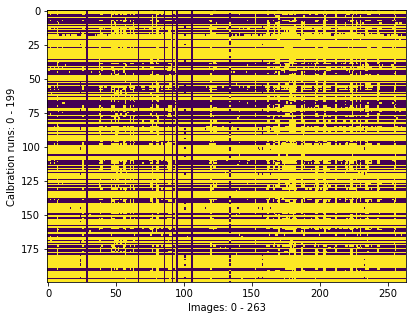

In [12]:
plt.figure(figsize=(10, 5))
plt.imshow(mask_both)
plt.xlabel('Images: 0 - {}'.format(mask_both.shape[1] - 1))
_ = plt.ylabel('Calbration runs: 0 - {}'.format(mask_both.shape[0] - 1))

## Analyze masked `mdir`

In [13]:
masked_mdir = MaskedValues(mdir, target=20., mask=mask_both)

In [14]:
df = masked_mdir.df_sorted().dropna()

df['SubsetSize'] = [len(subsets[idx]) for idx in df.index]
df['PlaneRMSMean'] = [plane_rms_all[idx][mask_both[idx]].mean() for idx in df.index]

df.head(10)

,Mean,StdDev,NGoodImages,MaxAbsErr,Hist0,Hist1,Hist2,Hist3,Hist4,Hist5,Hist6,Hist7,Hist8,Hist9,Hist10,SubsetSize,PlaneRMSMean
195,20.089752,0.950947,257,4.309574,158,25,5,6,4,4,4,3,1,4,43,24,0.494542
92,20.073732,0.968548,257,4.492296,142,19,17,13,5,4,6,2,1,5,43,25,0.501276
154,20.066356,0.947566,257,4.205867,140,23,22,9,4,6,2,2,1,3,45,16,0.540565
193,20.156560,0.985556,257,4.366292,134,22,20,14,9,4,2,6,2,2,42,17,0.577554
103,20.161985,0.980741,257,4.670504,133,47,7,7,4,4,4,0,2,4,45,27,0.509339
163,20.064004,0.962311,257,4.334908,131,24,20,9,12,4,5,3,1,3,45,27,0.491683
159,20.060556,0.933664,257,4.060692,128,36,20,8,8,3,4,2,3,2,43,23,0.500919
122,20.075398,0.964407,257,4.368642,124,45,14,8,5,5,6,1,1,5,43,15,0.516407
51,20.044293,0.926113,257,4.143052,120,32,25,10,13,2,4,3,3,3,42,17,0.503697
33,20.046137,0.976130,258,4.998884,112,34,16,17,13,10,4,2,2,4,44,17,0.539851


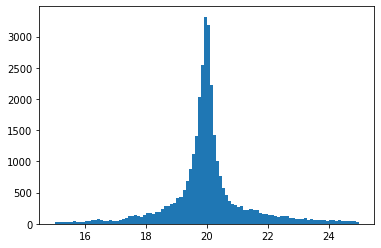

In [15]:
_ = plt.hist(mdir[mask_both], bins=100)

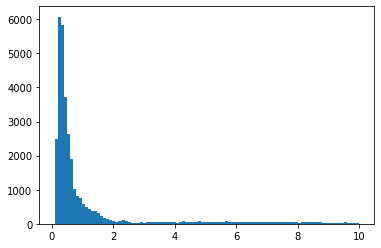

In [16]:
_ = plt.hist(plane_rms_all[mask_both], bins=100)

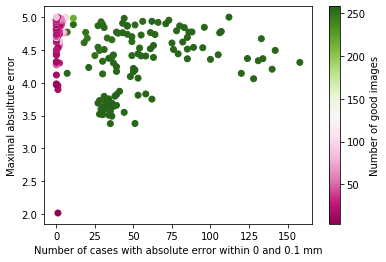

In [17]:
plot_hist0_maxabserr(df, df.NGoodImages, 'Number of good images')

## Comparing histograms

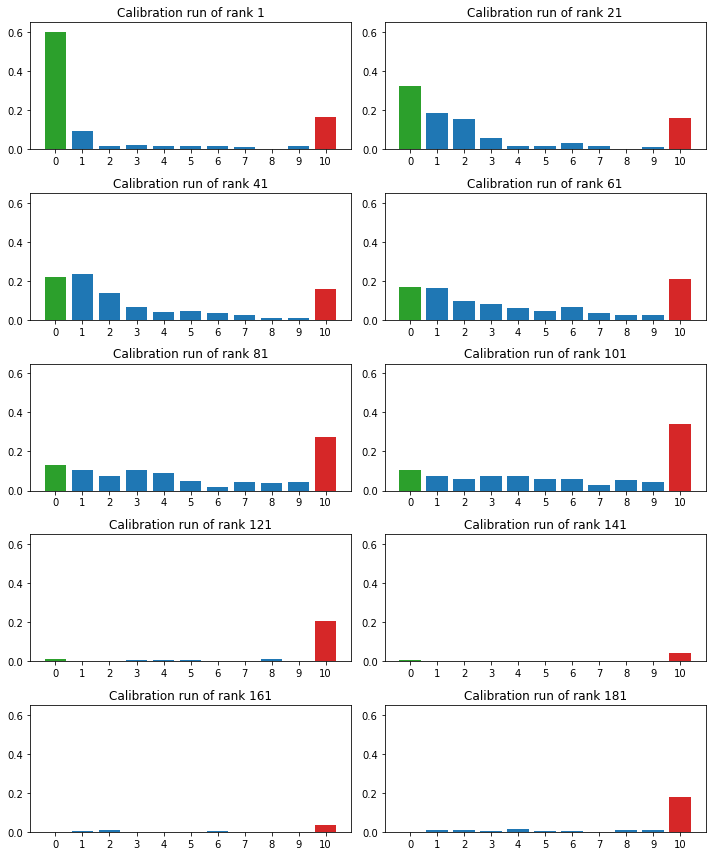

In [18]:
n_images = mdir.shape[1]

plot_histograms_for_ranks(df, n_images, step_size=20)

## PCA and KMeans

In [19]:
pca = PCA(n_components=2, random_state=42)

pca.fit(df)
X_pca = pca.transform(df)

In [20]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [21]:
labels = check_labels(kmeans.labels_, df)

In [22]:
df_good = df[labels == 1]
df_bad = df[labels == 0]

print('Size of the "good" cluster:', len(df_good))
print('Size of the "bad" cluster:', len(df_bad))

Size of the "good" cluster: 114
Size of the "bad" cluster: 85


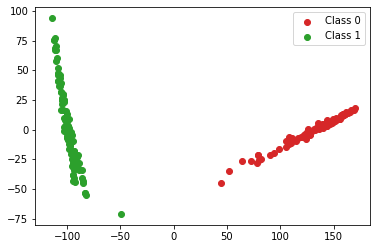

In [23]:
plt.scatter(
    X_pca[labels == 0][:, 0], 
    X_pca[labels == 0][:, 1], 
    c='tab:red', 
    label='Class 0', 
)

plt.scatter(
    X_pca[labels == 1][:, 0], 
    X_pca[labels == 1][:, 1], 
    c='tab:green', 
    label='Class 1', 
)

_ = plt.legend()

In [24]:
h_ratio = df.Hist0 / df.Hist10

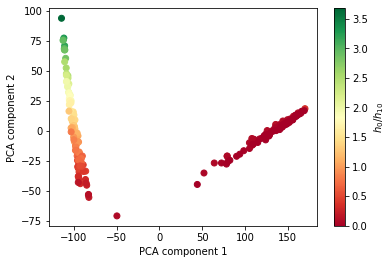

In [25]:
plot_scatter_with_colorbar(X_pca[:, 0], X_pca[:, 1], h_ratio, '$h_{0}/h_{10}$', colormap='RdYlGn')
plt.xlabel('PCA component 1')
_ = plt.ylabel('PCA component 2')

## Accuracy measurements

In [26]:
pairs_scores = np.sum(mask_mdir, axis=0)
best_pair_index = np.argmax(pairs_scores)
best_pair_score = pairs_scores[best_pair_index]

In [27]:
df_acc = calibim.gather_accuracy_measurements(triang, df, best_pair_index, n_first=100, nominal=20., psize=(9, 7))

df_acc.head(10)

,Mean,StdDev,MeanDeviation
195,20.020106,0.036709,0.020106
92,19.987229,0.061716,0.012771
154,20.028028,0.043530,0.028028
193,19.975203,0.055019,0.024797
103,20.042453,0.035712,0.042453
163,19.988801,0.067536,0.011199
159,20.045772,0.057521,0.045772
122,19.929305,0.084441,0.070695
51,20.092958,0.032249,0.092958
33,20.080412,0.064263,0.080412


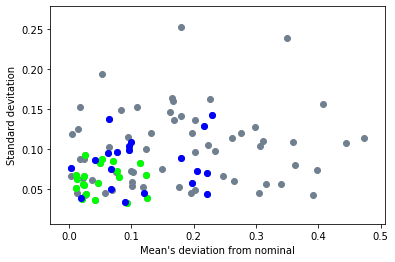

In [28]:
df_acc_1 = df_acc.iloc[:20]
df_acc_2 = df_acc.iloc[20:40]

plt.scatter(df_acc.MeanDeviation, df_acc.StdDev, color='slategray')

plt.scatter(df_acc_1.MeanDeviation, df_acc_1.StdDev, color='lime')
plt.scatter(df_acc_2.MeanDeviation, df_acc_2.StdDev, color='blue')

plt.xlabel("Mean's deviation from nominal")
plt.ylabel("Standard devitation")
plt.show()

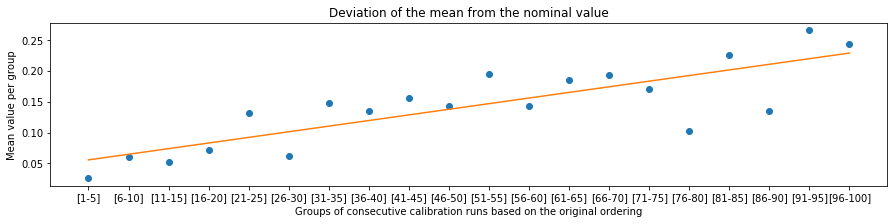

In [29]:
consec_md, groups = gather_from_df_acc_for_consecutive_groups(df_acc, 'MeanDeviation', group_size=5, n_groups=20)

plot_consec(consec_md, groups)
plt.title('Deviation of the mean from the nominal value')
plt.show()

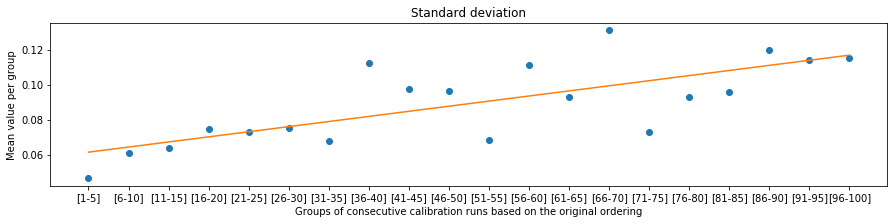

In [30]:
consec_sd, groups = gather_from_df_acc_for_consecutive_groups(df_acc, 'StdDev', group_size=5, n_groups=20)

plot_consec(consec_sd, groups)
plt.title('Standard deviation')
plt.show()